In [9]:
import warnings
warnings.filterwarnings("ignore")
import jieba
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [11]:
# from douban_movie2.crawl_movies import get_hot_movie
%matplotlib inline
mpl.rcParams['figure.figsize']=(10.0,5.0)

In [14]:
data_com = pd.read_csv('./data/comment.csv')

# 1.数据预处理(去重,去除太短的评论)
data_com.drop_duplicates(inplace=True)
data_com = data_com.drop(['user', 'is_watch', 'use_count'], axis=1)
# data_com['comment'] = data_com['comment'].apply(lambda x: len(str(x)) > 5)
# mark: like: star >= 3 unlike: star < 3
data_com['label'] = (data_com.star >= 3) * 1
data_com.info()
data_com.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7642 entries, 0 to 7644
Data columns (total 5 columns):
movie           7642 non-null object
star            7435 non-null float64
comment_time    7613 non-null object
comment         7612 non-null object
label           7642 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 358.2+ KB


,movie,star,comment_time,comment,label
0,惊奇队长,5.0,2019-03-08 00:51:47,没想到还有这么多停留在春晚选花魁的审美，也活该养出次方AB和海量烂片。觉得女主有问题的拜托去...,1
1,惊奇队长,2.0,2019-03-06 00:15:25,典型的漫威套路但是细节做得太差了，想通过女权女性觉醒作为卖点，然而内容脆弱得不堪一击。女主角...,0


Text(0.5, 0, 'Number of short_comment of each movie')

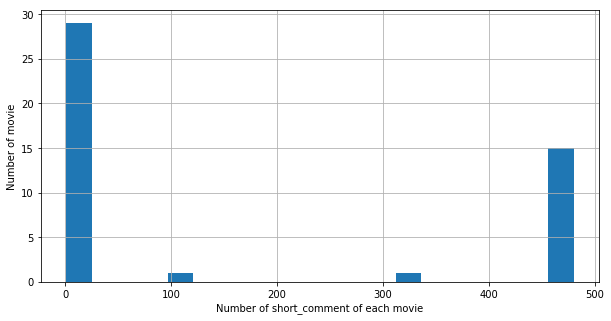

In [15]:
# 电影短评论数量分布(总体分布可见下图，横轴是每个电影的短评量，纵轴是相应的电影个数)
data_com.movie.value_counts().hist(bins=20)
plt.ylabel('Number of movie')
plt.xlabel('Number of short_comment of each movie')

In [16]:
# 惊奇队长
data_com_X = data_com[data_com.movie == '惊奇队长']
print('爬取《惊奇队长》的短评数：', data_com_X.shape[0])
# print(data_com_X)

爬取《惊奇队长》的短评数： 478


Text(0, 0.5, 'Number of short_comment')

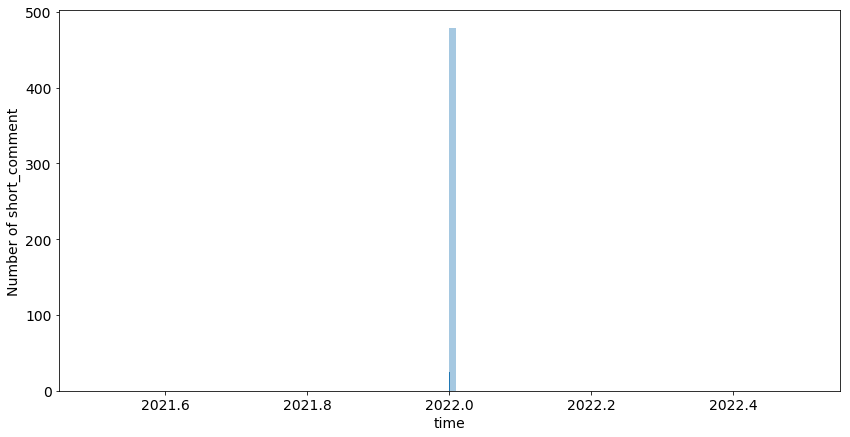

In [17]:
# small comment
mpl.rc('figure', figsize=(14, 7))
mpl.rc('font', size=14)
mpl.rc('axes', grid=False)
mpl.rc('axes', facecolor='white')
sns.distplot(data_com_X.comment_time.apply(lambda x: int(x[0:4]) + int(x[5:7]))
             , bins=100, kde=False, rug=True)
plt.xlabel('time')
plt.ylabel('Number of short_comment')

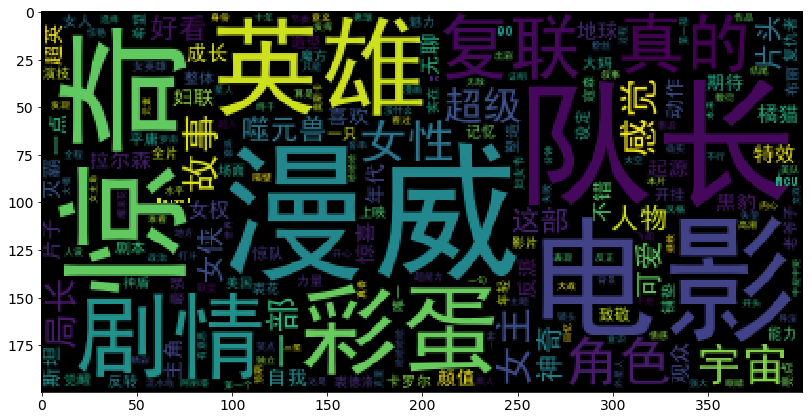

In [22]:
# 2.短评词云
content_X = data_com_X.comment.dropna().values.tolist()
# 导入,分词
segment = []
for line in content_X:
    try:
        segs = jieba.lcut(line)
        for seg in segs:
            if len(seg) > 1 and seg != '\r\n':
                segment.append(seg)
    except Exception as e:
        # print(line)
        continue

# 去停用词
words_df = pd.DataFrame({'segment': segment})
stopwords = pd.read_csv('./data/stopwords.txt', index_col=False, quoting=3, sep='\t', names=['stopword'], encoding='utf-8')
words_df = words_df[~words_df.segment.isin(stopwords.stopword)]
# 统计词频
words_stat = words_df.groupby(by=['segment'])['segment'].agg({'计数': np.size})
words_stat = words_stat.reset_index().sort_values(by=['计数'], ascending=False)
# print(words_stat.head())

# 词云
word_cloud = WordCloud(font_path='./data/simhei.ttf', background_color='black', max_font_size=80)
words_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}
# print(words_frequence)
word_cloud = word_cloud.fit_words(words_frequence)
plt.imshow(word_cloud)

In [23]:
# 3.根据短评文本和点评人是否喜欢作为训练数据，构建情感褒贬分析分类器
data_com_X.label.value_counts()

1    356
0    122
Name: label, dtype: int64

In [ ]:
# 用CNN做中文文本分类,数据预处理
stopwords = pd.read_csv('./data/stopwords.txt', index_col=False, quoting=3, sep='\t', names=['stopword'], encoding='utf-8')
stopwords = stopwords.values

def preprocess_text(content_lines, sentences, category):
    """
    文本预处理
    """
